## Setup & Libraries

In [33]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Load Dataset
Also Getting Shape of Data Set

In [4]:
file_path = Path("Data Set For Task") / "1) iris.csv"
data = pd.read_csv(file_path)
print("Dataset shape:", data.shape)

Dataset shape: (150, 5)


### Checking Missing Values Exist or Not
Incase Exist Remove values othervise simply skip them

In [5]:
missing_count = data.isna().sum().sum()  # total missing cells in the DataFrame

if missing_count > 0:
    print(f"Missing values found: {missing_count}, removing rows...")
    data = data.dropna()
else:
    print("No missing values found — skipping removal.")

print(f"Final shape: {data.shape}")

No missing values found — skipping removal.
Final shape: (150, 5)


### Remove duplicate rows

In [6]:
# Before removing
print(f"Before: {data.shape[0]} rows")

data = data.drop_duplicates()

# After removing
print(f"After: {data.shape[0]} rows")


Before: 150 rows
After: 147 rows


### Removing Inconsistent Data Types

Inconsistent Data Types: If you expect a column to be numeric but it’s showing as object.
There is no inconsistent in our data file.

### Exploratory Data Analysis (EDA)
#### Calculate summary statistics (mean, median, mode,standard deviation)

In [7]:
numeric_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Summary statistics
summary_stats = pd.DataFrame({
    "mean": data[numeric_cols].mean(),
    "median": data[numeric_cols].median(),
    "mode": data[numeric_cols].mode().iloc[0],  # mode() returns a DataFrame
    "std_dev": data[numeric_cols].std()
})

print(summary_stats)

                  mean  median  mode   std_dev
sepal_length  5.856463     5.8   5.0  0.829100
sepal_width   3.055782     3.0   3.0  0.437009
petal_length  3.780272     4.4   1.4  1.759111
petal_width   1.208844     1.3   0.2  0.757874


#### Visualize data distributions using histograms, boxplots,and scatter plots.
##### Histograms - distribution per numeric feature
What it shows: The distribution of a single numeric feature (shape: normal, skewed, multimodal).
When to use: First look after cleaning. Answer: “What values are common? Any skew? Multiple peaks?”
How it helps you decide:

Skewed right/left? → consider log/Box-Cox transform before modeling.

Weird spikes/gaps? → possible data-entry artifacts or binning issues.

Multimodal? → there may be subgroups/classes driving it (e.g., species).
Tweak tips:

bins=10/20/30 — try a few; too few hides structure, too many looks noisy.

Always dropna() to avoid crash.

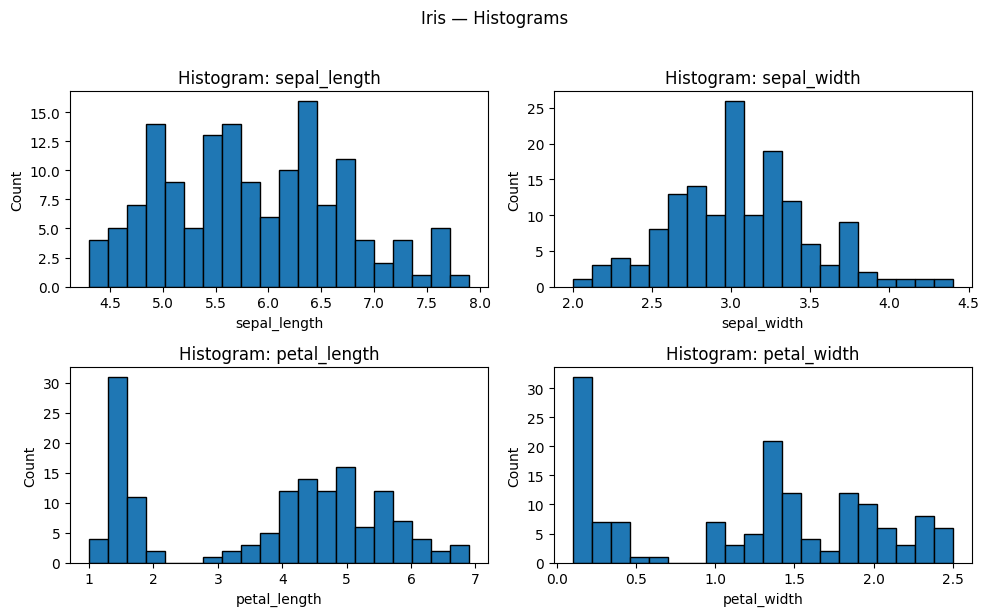

In [8]:
fig = plt.figure(figsize=(10, 6))
for i, col in enumerate(numeric_cols, start=1):
    ax = fig.add_subplot(2, 2, i)
    ax.hist(data[col].dropna(), bins=20, edgecolor='black')
    ax.set_title(f"Histogram: {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
fig.suptitle("Iris — Histograms", y=1.02)
fig.tight_layout()
# fig.savefig("histograms.png", dpi=150, bbox_inches="tight")
plt.show()

##### Boxplots — spot outliers quickly
What it shows: Median, quartiles, and outliers for one numeric feature.
When to use: Quick outlier scan and spread comparison across features.
How it helps you decide:

Extreme points? → investigate, cap (winsorize), or remove if invalid.

IQR spread big/small? → informs feature scaling; large spread may dominate models.

Comparing features → which ones are tight vs. noisy.
Tweak tips:

If a feature has many identical values, box can look squashed—normal.

For group comparisons (by species), use a grouped boxplot per species (optional).

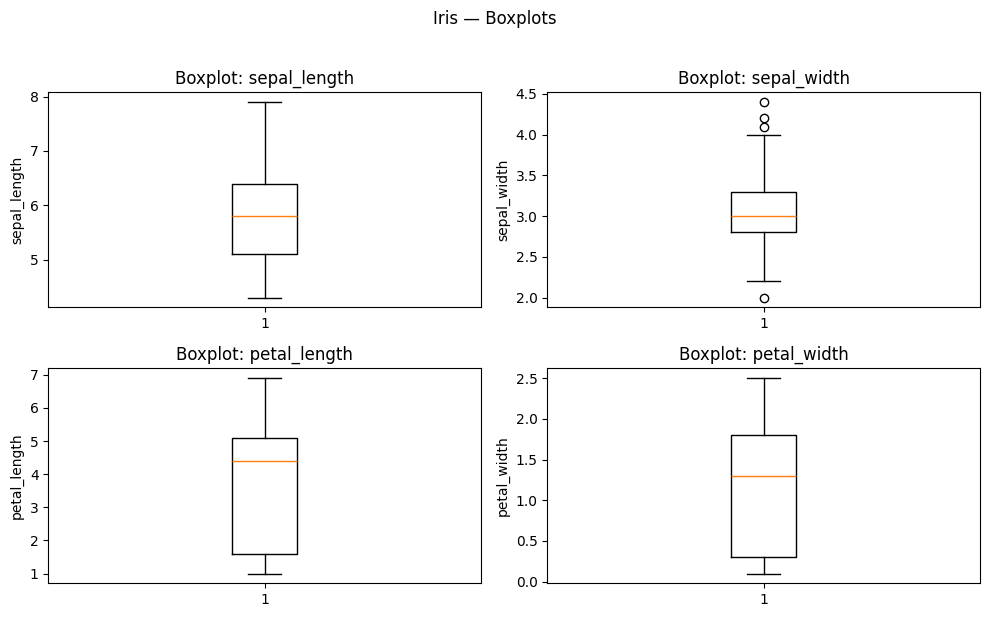

In [9]:
fig = plt.figure(figsize=(10, 6))
for i, col in enumerate(numeric_cols, start=1):
    ax = fig.add_subplot(2, 2, i)
    ax.boxplot(data[col].dropna(), vert=True)
    ax.set_title(f"Boxplot: {col}")
    ax.set_ylabel(col)
fig.suptitle("Iris — Boxplots", y=1.02)
fig.tight_layout()
# fig.savefig("boxplots.png", dpi=150, bbox_inches="tight")
plt.show()


##### Scatter plots — relationships (by species)
What it shows: Relationship between two numeric features (+ class separation via color/legend).
When to use: Explore correlation, clusters, class separability.
How it helps you decide:

Linear trend? → features might be redundant; consider dimensionality reduction.

Clear class separation? → these features are strong for classification.

Heteroscedasticity (fan shape)? → watch out with linear models; maybe transform.
Tweak tips:

Use different markers or alpha if points overlap; sample if you have huge data.

Try multiple pairs: sepal vs sepal, petal vs petal, cross (sepal vs petal).

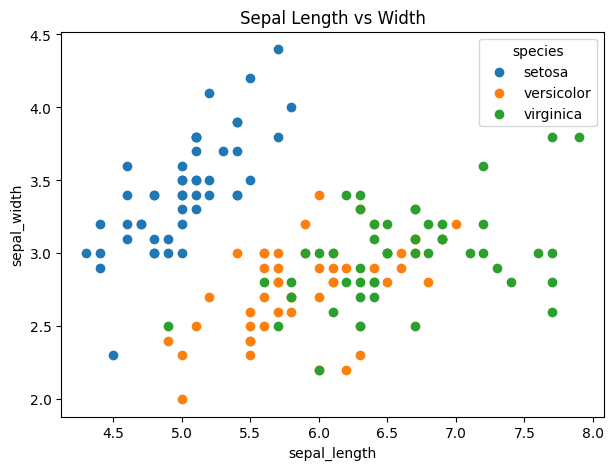

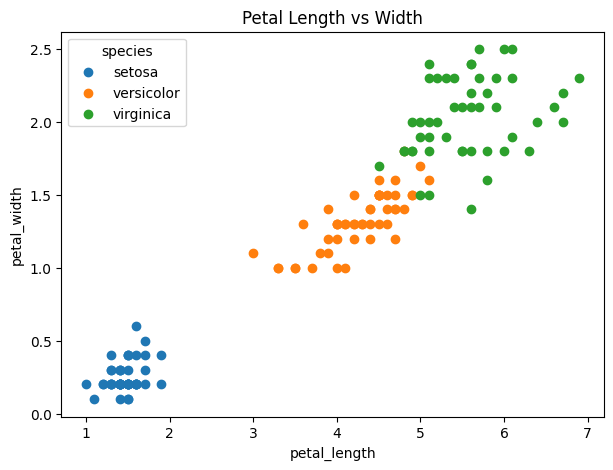

In [10]:
# Ensure species is usable for grouping
species_vals = data['species'].dropna().astype(str).unique()

# Sepal: length vs width
plt.figure(figsize=(7, 5))
for sp in species_vals:
    subset = data[data['species'] == sp]
    plt.scatter(subset['sepal_length'], subset['sepal_width'], label=sp)
plt.title("Sepal Length vs Width")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.legend(title="species")
# plt.savefig("scatter_sepal.png", dpi=150, bbox_inches="tight")
plt.show()

# Petal: length vs width
plt.figure(figsize=(7, 5))
for sp in species_vals:
    subset = data[data['species'] == sp]
    plt.scatter(subset['petal_length'], subset['petal_width'], label=sp)
plt.title("Petal Length vs Width")
plt.xlabel("petal_length")
plt.ylabel("petal_width")
plt.legend(title="species")
# plt.savefig("scatter_petal.png", dpi=150, bbox_inches="tight")
plt.show()


##### Scatter Matrix
What it shows: All pairwise scatter plots + histograms on the diagonal.
When to use: Fast overview to spot trends, correlations, and outliers across all numeric features at once.
How it helps you decide:

Instantly surfaces the strongest relationships to double-click on later.

Helps choose which feature pairs go into detailed scatter plots or modeling interactions.
Tweak tips:

Works best with ≤10 numeric columns; beyond that it’s clutter city.

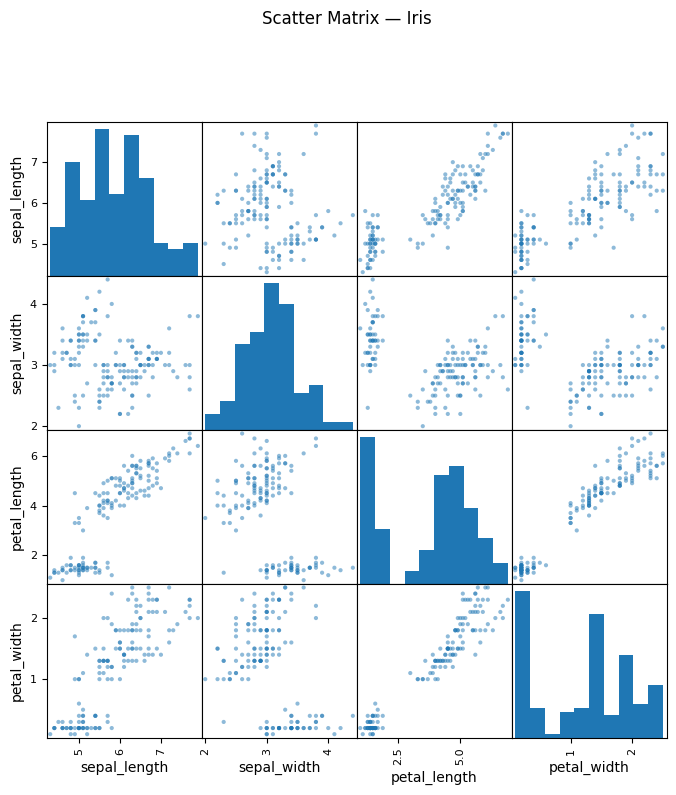

In [11]:
from pandas.plotting import scatter_matrix
scatter_matrix(data[numeric_cols], figsize=(8, 8), diagonal='hist')
plt.suptitle("Scatter Matrix — Iris", y=1.02)
plt.show()


#### Find correlations between numerical features.
Step 1 — Compute correlation matrix

In [12]:
# Pearson correlation (default) between numeric columns
corr_matrix = data[numeric_cols].corr()

print("Correlation Matrix:")
print(corr_matrix)


Correlation Matrix:
              sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.109321      0.871305     0.817058
sepal_width      -0.109321     1.000000     -0.421057    -0.356376
petal_length      0.871305    -0.421057      1.000000     0.961883
petal_width       0.817058    -0.356376      0.961883     1.000000


Step 2 — Visualize correlations

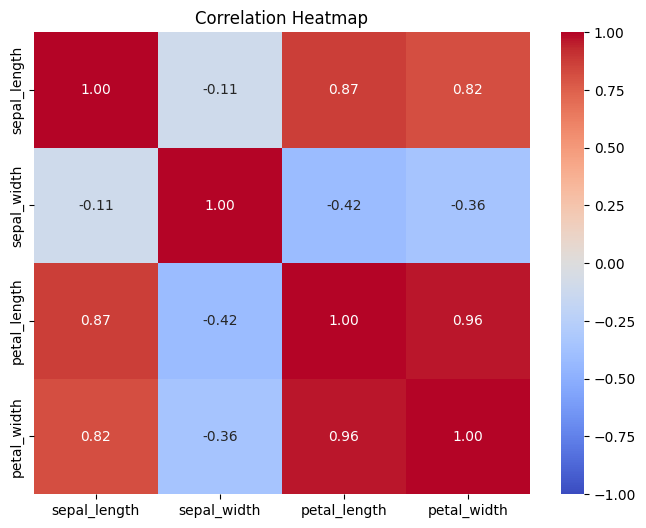

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,        # show numbers
    fmt=".2f",         # 2 decimal places
    cmap="coolwarm",   # color scheme
    vmin=-1, vmax=1    # consistent scale
)
plt.title("Correlation Heatmap")
plt.show()

Step 3 — How to interpret
High positive (close to 1) → features move together (likely redundant for some models).

High negative (close to -1) → features move in opposite directions.

Near zero → little to no linear relationship.

### Basic Data Visualization
#### Create bar plots, line charts, and scatter plots
A) Bar Plot
Shows categories vs values — best for discrete comparisons.

C:\Users\AUNS\AppData\Local\Temp\ipykernel_4280\4234740426.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="species", y="petal_length", data=avg_petal_length, palette="viridis")


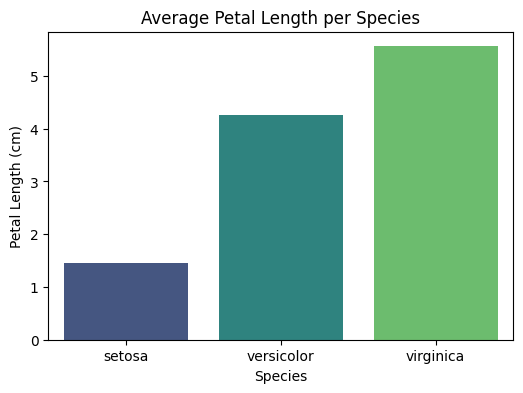

In [14]:
avg_petal_length = data.groupby("species")["petal_length"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x="species", y="petal_length", data=avg_petal_length, palette="viridis")
plt.title("Average Petal Length per Species")
plt.xlabel("Species")
plt.ylabel("Petal Length (cm)")
plt.show()

B) Line Chart <br>
Best for time series or ordered sequences. Iris doesn’t have time, so we’ll simulate with index.


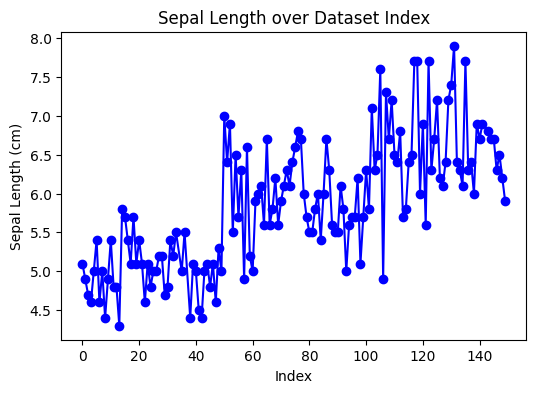

In [15]:
plt.figure(figsize=(6,4))
plt.plot(data.index, data["sepal_length"], marker='o', linestyle='-', color='blue')
plt.title("Sepal Length over Dataset Index")
plt.xlabel("Index")
plt.ylabel("Sepal Length (cm)")
plt.show()


C) Scatter Plot <br>
Best for relationships between two numeric variables.

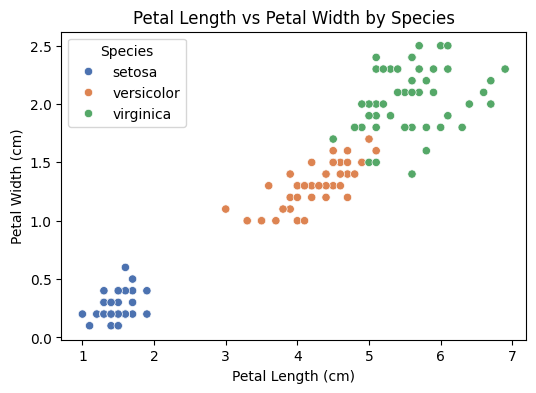

In [16]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="petal_length", y="petal_width", hue="species", data=data, palette="deep")
plt.title("Petal Length vs Petal Width by Species")
plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")
plt.legend(title="Species")
plt.show()


2) Customize plot labels, titles, and legends <br>
Already done above, but here’s the breakdown: 

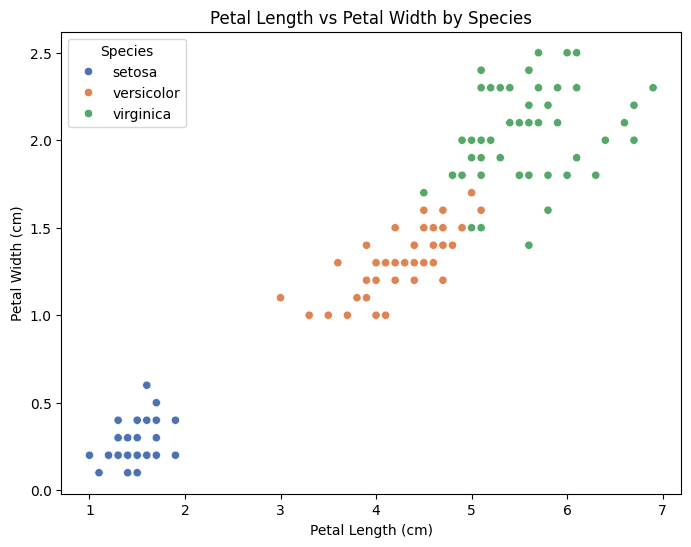

In [17]:
plt.figure(figsize=(8,6))   # create a figure with size
sns.scatterplot(x="petal_length", y="petal_width", hue="species", data=data, palette="deep")

plt.title("Petal Length vs Petal Width by Species") 
plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")
plt.legend(title="Species")

plt.show()

#### 3) Export plots as images

C:\Users\AUNS\AppData\Local\Temp\ipykernel_4280\1776282650.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="species", y="petal_length", data=avg_petal_length, palette="viridis")


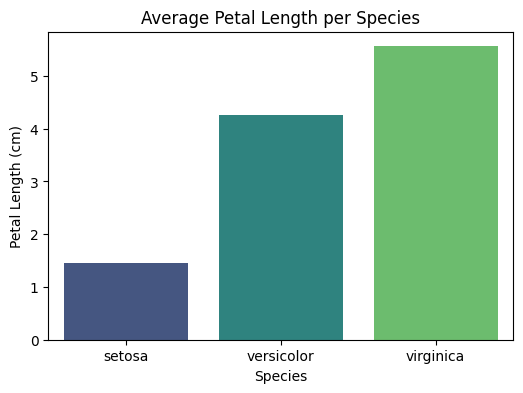

In [18]:
plt.figure(figsize=(6,4))
sns.barplot(x="species", y="petal_length", data=avg_petal_length, palette="viridis")
plt.title("Average Petal Length per Species")
plt.xlabel("Species")
plt.ylabel("Petal Length (cm)")

# Save before plt.show()
plt.savefig("avg_petal_length.png", dpi=300, bbox_inches='tight')
plt.show()


### Regression Analysis
#### Define features (X) and target (y)

#### In Iris, the features are the numeric columns, and the target is species.

In [20]:
X = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]  # features
y = data['species']  # target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Train labels distribution:\n", y_train.value_counts())
print("Test labels distribution:\n", y_test.value_counts())


Train set size: (117, 4)
Test set size: (30, 4)
Train labels distribution:
 species
versicolor    40
virginica     39
setosa        38
Name: count, dtype: int64
Test labels distribution:
 species
versicolor    10
virginica     10
setosa        10
Name: count, dtype: int64


#### 👉 At this point you’ve got clean X_train, X_test, y_train, y_test ready for modeling.

##### Linear Regression → predicts continuous numbers. Good if we want, say, petal_length from other features.

##### Iris goal (usual) → predict species (categorical). That’s a classification problem.

##### So we will use Multinomial Logistic Regression (fast, interpretable, strong baseline). If you want max accuracy later, try an SVC (RBF).

In [22]:
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
)

# Train
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



C:\Users\AUNS\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


#### Interpret the coefficients and evaluate the model using metrics such as R-squared and mean squared error.

##### Get Coefficients & Intercept

##### Evaluate Model Performance

In [35]:
X = data.drop("species", axis=1)   # numeric features
y = data["species"]   
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
coef_df = pd.DataFrame(clf.coef_, columns=X.columns, index=clf.classes_)
print(coef_df)

Accuracy: 0.9666666666666667

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Confusion Matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
            sepal_length  sepal_width  petal_length  petal_width
setosa         -0.493113     0.839239     -2.335594    -0.987585
versicolor      0.481186    -0.326802     -0.144936    -0.842870
virginica       0.011926    -0.512437      2.480529     1.830455


### Confusion Matrix Heatmap

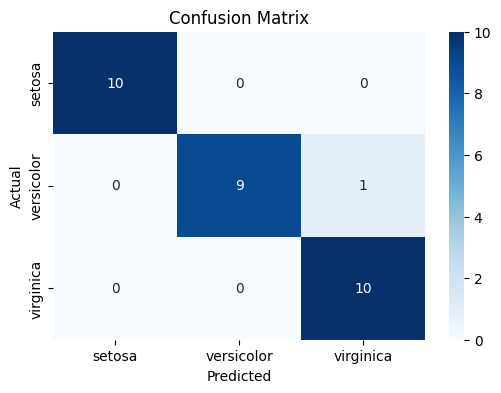

In [36]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Coefficient Bar Plot

<Figure size 800x600 with 0 Axes>

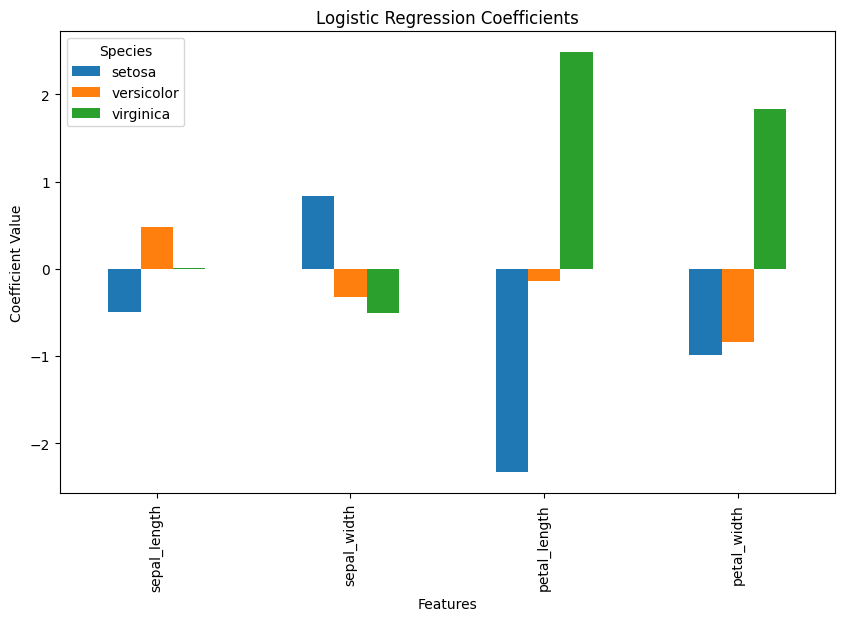

In [37]:
coef_df = pd.DataFrame(clf.coef_, columns=X.columns, index=clf.classes_)

plt.figure(figsize=(8,6))
coef_df.T.plot(kind="bar", figsize=(10,6))
plt.title("Logistic Regression Coefficients")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.legend(title="Species")
plt.show()

### Accuracy & Metrics Summary

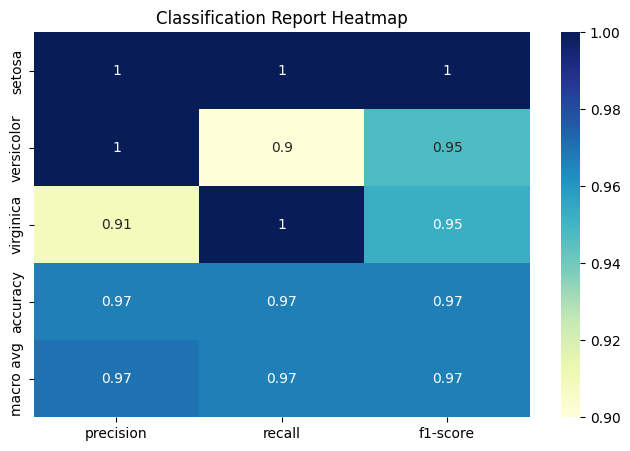

In [38]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8,5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.show()


### interactive prediction function using your trained logistic regression model.

In [39]:
def predict_species(sepal_length, sepal_width, petal_length, petal_width):
    # Put inputs into a DataFrame (model expects same format as training)
    input_data = pd.DataFrame([[sepal_length, sepal_width, petal_length, petal_width]],
                              columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
    
    # Predict species
    prediction = clf.predict(input_data)[0]
    proba = clf.predict_proba(input_data)[0]
    
    # Print results
    print(f"🌸 Predicted Species: {prediction}")
    print("📊 Probability distribution:")
    for sp, p in zip(clf.classes_, proba):
        print(f"  {sp}: {p:.2f}")


### Test our prediction function

In [40]:
predict_species(5.1, 3.5, 1.4, 0.2)  # Example input


🌸 Predicted Species: setosa
📊 Probability distribution:
  setosa: 0.98
  versicolor: 0.02
  virginica: 0.00
